In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

In [8]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    # Feature Engineering
    # Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Rare',
        'Rev': 'Rare',
        'Col': 'Rare',
        'Major': 'Rare',
        'Mlle': 'Miss',
        'Countess': 'Rare',
        'Ms': 'Miss',
        'Lady': 'Rare',
        'Jonkheer': 'Rare',
        'Don': 'Rare',
        'Dona': 'Rare',
        'Mme': 'Mrs',
        'Capt': 'Rare',
        'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)

    # Create family size feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Handle missing values
    df['Age'] = df['Age'].fillna(df.groupby(['Title', 'Pclass'])['Age'].transform('median'))
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('median'))

    # Create age bands using custom bins to avoid duplicate edges
    age_bins = [0, 12, 20, 30, 40, 50, 60, np.inf]
    age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior', 'Elderly']
    df['AgeBand'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

    # Remove outliers using IQR method
    def remove_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
        return df

    df = remove_outliers(df, 'Fare')
    df = remove_outliers(df, 'Age')

    # Feature scaling and encoding
    label_encoders = {}
    categorical_features = ['Sex', 'Title', 'Embarked']
    for feature in categorical_features:
        label_encoders[feature] = LabelEncoder()
        df[feature] = label_encoders[feature].fit_transform(df[feature].fillna('Missing'))

    scaler = StandardScaler()
    numerical_features = ['Age', 'Fare', 'FamilySize']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df, label_encoders, scaler

In [9]:
def create_advanced_visualizations(df):
    # Create a figure with adjusted size
    plt.figure(figsize=(20, 15))

    # 1. Survival Rate by Title and Class
    plt.subplot(3, 2, 1)
    sns.barplot(x='Title', y='Survived', hue='Pclass', data=df)
    plt.title('Survival Rate by Title and Class', fontsize=12)
    plt.xticks(rotation=45)

    # 2. Family Size Impact on Survival
    plt.subplot(3, 2, 2)
    sns.violinplot(x='Survived', y='FamilySize', data=df)
    plt.title('Family Size Distribution by Survival', fontsize=12)

    # 3. Age Band Analysis
    plt.subplot(3, 2, 3)
    survival_by_age = df.groupby('AgeBand')['Survived'].mean().reset_index()
    sns.barplot(x='AgeBand', y='Survived', data=survival_by_age)
    plt.title('Survival Rate by Age Group', fontsize=12)
    plt.xticks(rotation=45)

    # 4. Fare Distribution by Survival and Class
    plt.subplot(3, 2, 4)
    sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df)
    plt.title('Fare Distribution by Class and Survival', fontsize=12)

    # 5. Family Size and Class Interaction
    plt.subplot(3, 2, 5)
    sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=df)
    plt.title('Family Size by Class and Survival', fontsize=12)

    # 6. Survival Rate by Deck (derived from Cabin)
    plt.subplot(3, 2, 6)
    df['Deck'] = df['Cabin'].str.slice(0, 1).fillna('Unknown')
    sns.barplot(x='Deck', y='Survived', data=df)
    plt.title('Survival Rate by Deck', fontsize=12)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Additional visualization: Age distribution by survival and class
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df, x='Age', hue='Survived', multiple="stack")
    plt.title('Age Distribution by Survival Status')
    plt.show()


In [14]:
def train_and_evaluate_models(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models with default parameters
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    # Simple parameter grids
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5]
        }
    }

    for name, model in models.items():
        print(f"\n=== {name} Analysis ===")

        # Find best parameters
        grid_search = GridSearchCV(
            model,
            param_grids[name],
            cv=5,
            scoring='accuracy'
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Print results
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.3f}")

        # Feature importance plot
        plt.figure(figsize=(8, 4))
        importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=True)

        plt.barh(importance['Feature'], importance['Importance'])
        plt.title(f'{name} - Feature Importance')
        plt.tight_layout()
        plt.show()

Starting Titanic Data Analysis...

Generating basic visualizations...


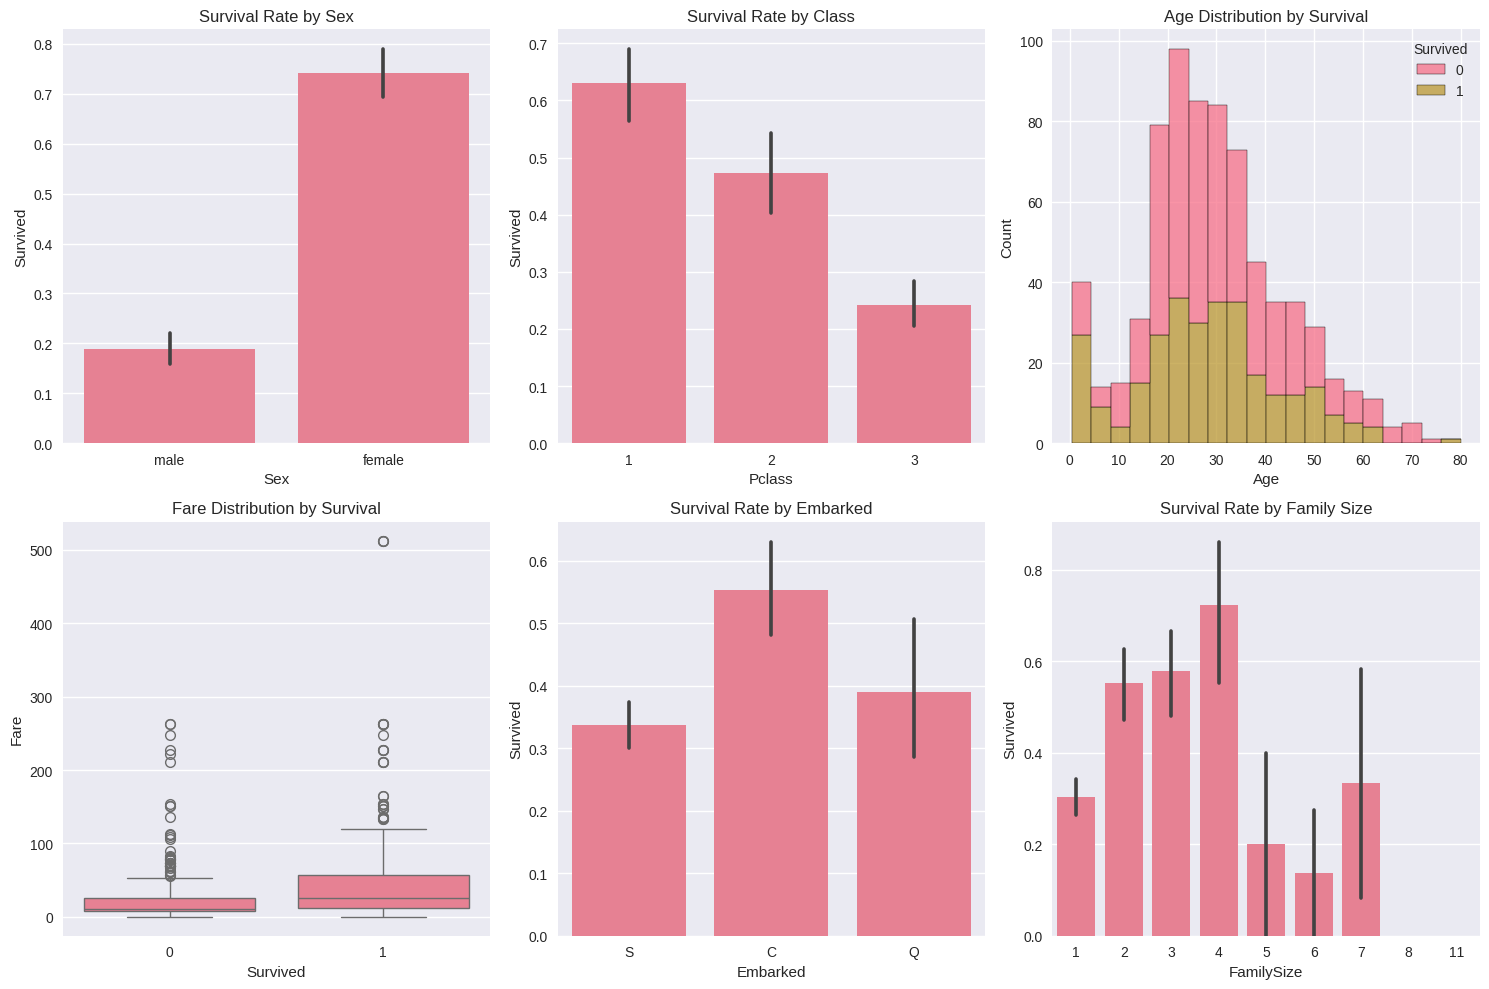


Generating correlation matrix...


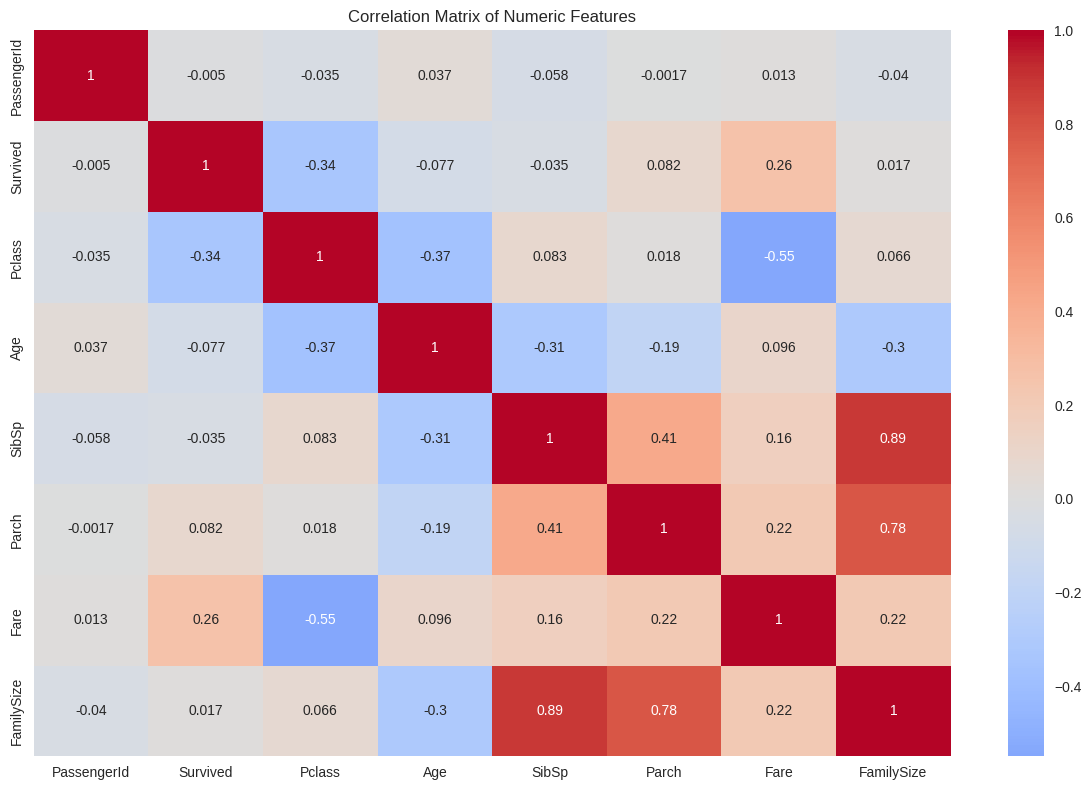


Preprocessing data and training model...

Generating feature importance plot...


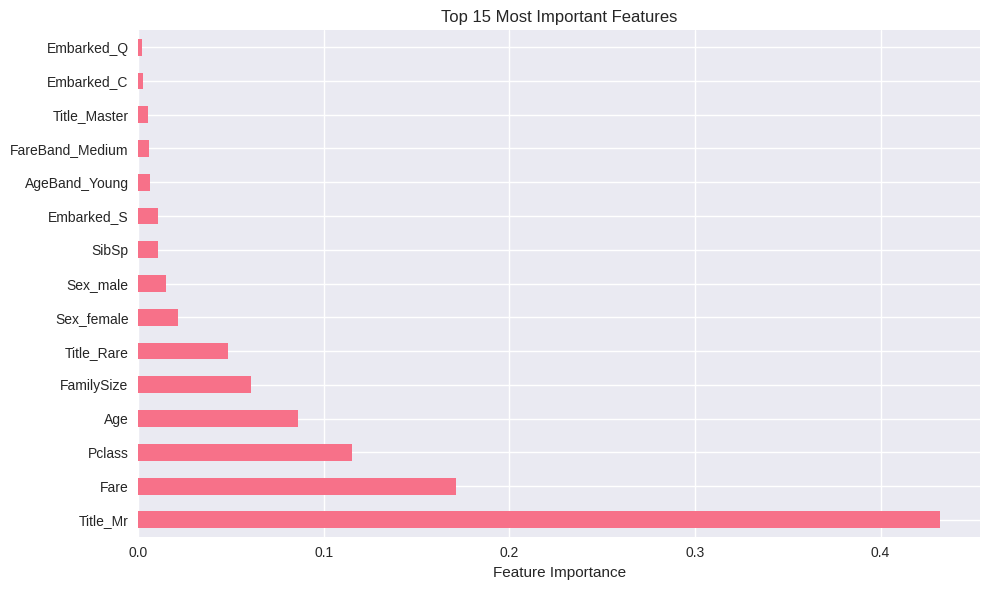


Analysis complete!

Sample Passenger Survival Probability: 0.95


In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class TitanicAnalyzer:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.preprocessed = False
        self.model = None
        self.feature_columns = None
        self.scaler = StandardScaler()

    def plot_basic_visualizations(self):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        sns.barplot(x='Sex', y='Survived', data=self.df, ax=axes[0,0])
        axes[0,0].set_title('Survival Rate by Sex')

        sns.barplot(x='Pclass', y='Survived', data=self.df, ax=axes[0,1])
        axes[0,1].set_title('Survival Rate by Class')

        sns.histplot(data=self.df, x='Age', hue='Survived', multiple="stack", ax=axes[0,2])
        axes[0,2].set_title('Age Distribution by Survival')

        sns.boxplot(x='Survived', y='Fare', data=self.df, ax=axes[1,0])
        axes[1,0].set_title('Fare Distribution by Survival')

        sns.barplot(x='Embarked', y='Survived', data=self.df, ax=axes[1,1])
        axes[1,1].set_title('Survival Rate by Embarked')

        self.df['FamilySize'] = self.df['SibSp'] + self.df['Parch'] + 1
        sns.barplot(x='FamilySize', y='Survived', data=self.df, ax=axes[1,2])
        axes[1,2].set_title('Survival Rate by Family Size')

        plt.tight_layout()
        plt.show()

    def extract_and_group_titles(self, min_frequency=10):
        self.df['Title'] = self.df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        title_counts = self.df['Title'].value_counts()

        rare_titles = title_counts[title_counts < min_frequency].index
        title_mapping = {title: title for title in title_counts.index}

        for title in title_mapping:
            if title in rare_titles:
                if any(word in title.lower() for word in ['mrs', 'ms', 'mme']):
                    title_mapping[title] = 'Mrs'
                elif any(word in title.lower() for word in ['miss', 'mlle']):
                    title_mapping[title] = 'Miss'
                elif title.lower() in ['mr', 'master']:
                    title_mapping[title] = title.capitalize()
                else:
                    title_mapping[title] = 'Rare'

        self.title_mapping = title_mapping
        return title_mapping

    def preprocess_data(self):
        def remove_outliers(df, column):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

        self.df['FamilySize'] = self.df['SibSp'] + self.df['Parch'] + 1
        self.df['IsAlone'] = (self.df['FamilySize'] == 1).astype(int)

        title_mapping = self.extract_and_group_titles()
        self.df['Title'] = self.df['Title'].map(title_mapping)

        self.fare_bands = pd.qcut(self.df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
        self.fare_band_ranges = pd.qcut(self.df['Fare'], 4, retbins=True)[1]

        self.age_band_ranges = pd.cut(self.df['Age'], 5, labels=['Child', 'Young', 'Adult', 'Middle', 'Senior'], retbins=True)[1]

        self.df['FareBand'] = self.fare_bands
        self.df['AgeBand'] = pd.cut(self.df['Age'], 5, labels=['Child', 'Young', 'Adult', 'Middle', 'Senior'])

        self.df['Age'].fillna(self.df.groupby(['Pclass', 'Title'])['Age'].transform('median'), inplace=True)
        self.df['Embarked'].fillna(self.df['Embarked'].mode()[0], inplace=True)

        self.sex_mapping = {'male': 1, 'female': 0}

        categorical_features = ['Sex', 'Embarked', 'Title', 'FareBand', 'AgeBand']
        self.df = pd.get_dummies(self.df, columns=categorical_features)

        self.features = [col for col in self.df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]
        self.feature_columns = self.features.copy()

        self.X = self.df[self.features]
        self.y = self.df['Survived']

        numerical_features = ['Age', 'Fare', 'FamilySize']
        self.X[numerical_features] = self.scaler.fit_transform(self.X[numerical_features])

        self.preprocessed = True

    def plot_correlation_matrix(self):
        plt.figure(figsize=(12, 8))
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        correlation_matrix = self.df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numeric Features')
        plt.tight_layout()
        plt.show()

    def process_new_passenger(self, passenger_data):
        processed = pd.DataFrame(columns=self.feature_columns)
        processed.loc[0] = 0

        if 'Age' in passenger_data:
            age = passenger_data['Age']
            processed['Age'] = age
            age_band = pd.cut([age], bins=self.age_band_ranges, labels=['Child', 'Young', 'Adult', 'Middle', 'Senior'])[0]
            processed[f'AgeBand_{age_band}'] = 1

        if 'Fare' in passenger_data:
            fare = passenger_data['Fare']
            processed['Fare'] = fare
            fare_band = pd.cut([fare], bins=self.fare_band_ranges, labels=['Low', 'Medium', 'High', 'Very High'])[0]
            processed[f'FareBand_{fare_band}'] = 1

        if 'Pclass' in passenger_data:
            processed[f'Pclass'] = passenger_data['Pclass']

        if 'Sex' in passenger_data:
            sex_val = passenger_data['Sex'].lower()
            processed[f'Sex_{sex_val}'] = 1

        if 'Embarked' in passenger_data:
            embarked_val = passenger_data['Embarked'].upper()
            processed[f'Embarked_{embarked_val}'] = 1

        family_size = (passenger_data.get('SibSp', 0) + passenger_data.get('Parch', 0) + 1)
        processed['FamilySize'] = family_size
        processed['IsAlone'] = int(family_size == 1)

        numerical_features = ['Age', 'Fare', 'FamilySize']
        processed[numerical_features] = self.scaler.transform(processed[numerical_features].values.reshape(1, -1))

        return processed

    def train_model(self):
        if not self.preprocessed:
            self.preprocess_data()

        rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        rf_scores = cross_val_score(rf, self.X, self.y, cv=cv, scoring='roc_auc')
        gb_scores = cross_val_score(gb, self.X, self.y, cv=cv, scoring='roc_auc')

        if rf_scores.mean() > gb_scores.mean():
            self.model = rf
        else:
            self.model = gb

        self.model.fit(self.X, self.y)

    def plot_feature_importance(self):
        if self.model is None:
            self.train_model()

        plt.figure(figsize=(10, 6))
        importances = pd.Series(self.model.feature_importances_, index=self.features)
        importances.nlargest(15).plot(kind='barh')
        plt.title('Top 15 Most Important Features')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()

    def get_survival_probability(self, passenger_data):
        if not self.preprocessed:
            self.preprocess_data()
        if self.model is None:
            self.train_model()

        processed_data = self.process_new_passenger(passenger_data)
        return self.model.predict_proba(processed_data)[:,1][0]

    def analyze_and_visualize(self):
        print("Starting Titanic Data Analysis...")
        print("\nGenerating basic visualizations...")
        self.plot_basic_visualizations()
        print("\nGenerating correlation matrix...")
        self.plot_correlation_matrix()
        print("\nPreprocessing data and training model...")
        self.preprocess_data()
        self.train_model()
        print("\nGenerating feature importance plot...")
        self.plot_feature_importance()
        print("\nAnalysis complete!")

if __name__ == "__main__":
    analyzer = TitanicAnalyzer('train.csv')
    analyzer.analyze_and_visualize()

    sample_passenger = {
        'Pclass': 1,
        'Sex': 'female',
        'Age': 30,
        'Fare': 100,
        'SibSp': 0,
        'Parch': 0,
        'Embarked': 'S'
    }

    survival_prob = analyzer.get_survival_probability(sample_passenger)
    print(f"\nSample Passenger Survival Probability: {survival_prob:.2f}")